In [8]:
#imports
from scipy.spatial import distance_matrix
from random import randrange
import copy
import matplotlib.pyplot as plt
import imageio
import imageio
import random
from time import time
from tqdm import tqdm

In [9]:
#loading datasets 
import numpy as np
kroa={}
krob={}
np_kroa=[]
np_krob=[]
with open('kroa200.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        kroa[x[0]]=(x[1],x[2])
        np_kroa.append((x[1],x[2]))
np_kroa=np.array(np_kroa)
with open('krob200.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        krob[x[0]]=(x[1],x[2])
        np_krob.append((x[1],x[2]))

np_kroa=np.array(np_kroa)
np_krob=np.array(np_krob)

#calculating distance matrix - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html
dista=distance_matrix(np_kroa,np_kroa)
distb=distance_matrix(np_krob,np_krob)

In [10]:
#plotting functions
def plotResult(np_dots, cycles):
    plt.plot(np_dots[:,0][cycles[0][0]], np_dots[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[1][0]], np_dots[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[0]], np_dots[:,1][cycles[0]], "->")
    plt.plot(np_dots[:,0][cycles[1]], np_dots[:,1][cycles[1]], "->")
    plt.show()
    
def plotPartResult(np_dots, cycles,i):
    plt.plot(np_dots[:,0][cycles[0][0]], np_dots[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[1][0]], np_dots[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[0]], np_dots[:,1][cycles[0]], "->")
    plt.plot(np_dots[:,0][cycles[1]], np_dots[:,1][cycles[1]], "->")
    plt.plot(np_dots[:,0], np_dots[:,1], ".")
    plt.savefig(f'plots/{i}.png')
    plt.show()    
def calcDistance(currentCycle, dist):
    distance = 0
    for x,y in zip(currentCycle, [*currentCycle[1:], currentCycle[0]]):
        distance += dist[x][y]
    return distance 

In [11]:
# 1st variable - Start cycle - with random assignments
def start_cycle_random(dataset_choice="kroa"):
    cycles={}
    cycles[0]=np.random.choice(100,50,replace=False)
    cycles[1]=np.array([i for i in np.arange(0,100,1) if i not in cycles[0]])
    np.random.shuffle(cycles[1])
    return cycles


In [12]:
# 3rd variable - Generate neighbour solution
#changes edges internally
def change_edges(cycles, edge1, edge2, internally=False): # dummy internally
    cI= 0 if len(np.where(cycles[0] == edge1)[0])!=0 else 1 
#     print(cycles[cI])
    inA=np.where(cycles[cI] == edge1)[0][0]
    inB=np.where(cycles[cI] == edge2)[0][0]
    inA += 1
    inB += 1
    cycle = cycles[cI]
    cycle[inA: inB] = np.flip(cycle[inA: inB])
    return cycles

In [13]:
# 3rd variable - Generate neighbour solution
#changes vertex internally or externaly between cycles
def change_vertices(cycles, a, b, internally=True):
    if internally:
#         print(len(np.where(cycles[0] == a)))
#         print(np.where(cycles[0] == a))
        cI= 0 if len(np.where(cycles[0] == a)[0])!=0 else 1 
        inA=np.where(cycles[cI] == a)[0][0]
        inB=np.where(cycles[cI] == b)[0][0]
        tmp=cycles[cI][inA]
        cycles[cI][inA]=b
        cycles[cI][inB]=tmp
        #print(cycles[0][inB], cycles[0][inA])
    else:
        cI= 0 if len(np.where(cycles[0] == a)[0])!=0 else 1 
        cI2 = 1-cI
        inA=np.where(cycles[cI] == a)[0][0]
        inB=np.where(cycles[cI2] == b)[0][0]
        tmp=cycles[cI][inA]
        cycles[cI][inA]=b
        cycles[cI2][inB]=tmp
        #pass
    #print(cycles)
    return cycles
    #if aIndex in cycles[0]
    #raise NotImplementedError

In [14]:
# 1st variable - Start cycle - with nearest neighbour method
def start_cycle_heuristic(dataset_choice="kroa"):
    results=[]
    min_result=np.inf
    max_result=0
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)


    #zmiana dystansu przekątnej na nieskonczonosc
    np.fill_diagonal(dist, np.inf)

    cycles={}
    cycles[0]=[randrange(100)]
    cycles[1]=[(np.argsort(dist[cycles[0][0]])[-2])]

    for b in range(2):
        dist[:,int(cycles[b][0])]=np.inf

    chosenCycle=1
    for i in range(0,98):
        chosenCycle = int((chosenCycle + 1)%2)
        candidates=[]
        for z,index in enumerate(cycles[chosenCycle]):
            candidates.append((np.argmin(dist[index]),np.min(dist[index]),z))
        candidates=np.array(candidates)
        x=np.argmin(candidates[:,1])
        cycles[chosenCycle]=np.insert(cycles[chosenCycle],int(candidates[x,2]),int(candidates[x,0]))
        dist[:,int(candidates[x,0])]=np.inf
    
    #print(f"cycle[0]: {calcDistance(cycles[0], dist_stable)}")
    #print(f"cycle[1]: {calcDistance(cycles[1], dist_stable)}")
    
    #SAVING RESULTS 
    results.append(calcDistance(cycles[0],dist_stable)+calcDistance(cycles[1],dist_stable))
    if results[-1]>max_result:
        max_result=results[-1]
    if results[-1]<min_result:
        min_result=results[-1]
#         plt.clf()
#         plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
#         plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)
#         plt.plot(dataset[:,0][cycles[0]], dataset[:,1][cycles[0]], "->")
#         plt.plot(dataset[:,0][cycles[1]], dataset[:,1][cycles[1]], "->")
#         plt.savefig(f'best_NN_{dataset_choice}.png')
    return cycles

In [15]:
# 2nd variable - Find more optimal solution
# switch parameter defines how u find neighbour solutions (is it change_vertices or change_edges func)
def greedy_search(dist, np_dots, init_random = False, switch="change_edges"):
    #specify cycles initialization.
    if init_random:
        cycles = start_cycle_random()
    else:
        cycles = start_cycle_heuristic()
        
    #print(cycles)
    
    if switch == "change_vertices":
        internal_change = change_vertices
    elif switch == "change_edges":
        internal_change = change_edges
    else:
        print(f"Unknow mode {switch}. Select change_vertices or change_edges")
        return
    
    
    
    bestDistance = 0
    bestDistance += calcDistance(cycles[0], dist) 
    bestDistance += calcDistance(cycles[1], dist) 
    #print(f"Initial distance: {bestDistance}")
    
    #plotPartResult(np_dots, cycles)
    
    
    done = False
    while not done:
        done = True
        #-------------calculating possible moves
        possible_moves = []
        
        mesh = np.array(np.meshgrid(cycles[0], cycles[1]))
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["external", x])

        mesh = np.array(np.meshgrid(cycles[0], cycles[0]))
        mesh = np.concatenate((mesh,np.array(np.meshgrid(cycles[1], cycles[1]))),axis=0)
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["internal", x])
        
        possible_moves = np.array(possible_moves)
        i = np.random.choice(range(len(possible_moves)),len(possible_moves),replace=False)
        possible_moves = possible_moves[i]
        

        for move, edges in possible_moves:
#             print(move, edges)
            cyclesCopy = copy.deepcopy(cycles)
            edge1 = edges[0]
            edge2 = edges[1]
            
#             print(edge1, edge2)
            if move == "internal":
                cyclesCopy = internal_change(cyclesCopy, edge1, edge2, internally=True)
            else:
                cyclesCopy = change_vertices(cyclesCopy, edge1, edge2, False)
#             plotPartResult(np_dots, cycles)
            currentDistance = 0
            currentDistance += calcDistance(cyclesCopy[0], dist)
            currentDistance += calcDistance(cyclesCopy[1], dist)
            if currentDistance < bestDistance:
                #print(f"New best distance: {currentDistance}, changed {edge1} with {edge2} on {move}")
                cycles = cyclesCopy
                bestDistance = currentDistance
                done = False
                break
    
#     plotPartResult(np_dots, cycles)
#     plt.show()
    return cycles, bestDistance
    

In [18]:
K = 2 # docelowo 10
N = 3 # docelowo 100



  0%|          | 0/3 [00:00<?, ?it/s]/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 33%|███▎      | 1/3 [00:13<00:26, 13.45s/it]

 67%|██████▋   | 2/3 [00:25<00:12, 12.93s/it]

100%|██████████| 3/3 [00:35<00:00, 11.77s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:12<00:25, 12.71s/it]

 67%|██████▋   | 2/3 [00:24<00:12, 12.58s/it]

100%|██████████| 3/3 [00:37<00:00, 12.34s/it]


  0%|          | 0/3 [00:00<?, ?it/s]/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant t

greedy_search- time_mean:36.16529047489166,  time_min:35.311578035354614, time_max:37.01900291442871, min:25755.19442979111, max:26756.168941350414, mean:26255.681685570762




 33%|███▎      | 1/3 [00:12<00:24, 12.19s/it]

 67%|██████▋   | 2/3 [00:23<00:11, 11.98s/it]

100%|██████████| 3/3 [00:35<00:00, 11.85s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:11<00:23, 11.96s/it]

 67%|██████▋   | 2/3 [00:26<00:12, 12.61s/it]

100%|██████████| 3/3 [00:37<00:00, 12.48s/it]


greedy_search- time_mean:36.49117910861969,  time_min:35.54196906089783, time_max:37.44038915634155, min:27690.98122373731, max:28002.029153696247, mean:27846.50518871678


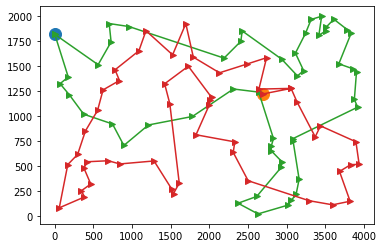

In [23]:
#MAIN - tu poskladac wyzej zaimplementowane funkcje w 8 roznych kombinacji algorytmow i sprawdzic ich czasy i wyplotowac skutecznosci


for dataset_choice in ['kroa', 'krob']:
    if dataset_choice=="kroa":
        dataset=np_kroa
        dist=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dist=copy.deepcopy(distb)
    
    timeTable = []
    cyclesTable = []
    distanceTable = []
    for _ in range(K):
        
        distanceTableBuffer = []
        cyclesTableBuffer = []
        bestDistance = 0
        startTime = time()
        for _ in tqdm(range(N)):

            cycles, bestDistance = greedy_search(dist, dataset, init_random = True, switch="change_edges")
            distanceTableBuffer.append(bestDistance)
            cyclesTableBuffer.append(cycles)
        timeTable.append(time() - startTime)
        distanceTable.append(np.min(distanceTableBuffer))
        cyclesTable.append( cyclesTableBuffer[np.argmin(distanceTableBuffer) ] )
    
    print(f"greedy_search- time_mean:{np.mean(timeTable)},  time_min:{np.min(timeTable)}, time_max:{np.max(timeTable)}, min:{np.min(distanceTable)}, max:{np.max(distanceTable)}, mean:{np.mean(distanceTable)}")


    cycles = cyclesTable[np.argmin(distanceTable)]
    plt.clf()
    plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)                
    plt.plot(dataset[:,0][[*cycles[0],cycles[0][0]]], dataset[:,1][[*cycles[0],cycles[0][0]]], "->")
    plt.plot(dataset[:,0][[*cycles[1],cycles[1][1]]], dataset[:,1][[*cycles[1],cycles[1][1]]], "->")
    plt.plot()
    
    plt.savefig(f'greedy_search_best_NN_randomTrue_changeEdges_{dataset_choice}.png')


##  (ILS1) Iterated local search - Iteracyjne przeszukiwanie lokalne z niewielką perturbacją,

## (ILS2) Iterated local search - Iteracyjne przeszukiwanie lokalne z Large-scale neighborhood search, tj. większą perturbacją typu Destroy-Repair.